# SIGLE: Selective Inference in Generalized Linear models through conditional MLE
# The case of the Sparse Logistic Regression


### Authors: Quentin Duchemin & Yohann De Castro

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from inverse_map import inverse_map, train_network
import torch
import scipy
import scipy as sc
import scipy.stats
from PSIGLL import *

# I) SEI-SLR

In [ ]:
n,p = 11,10
X = np.random.normal(0,1,(n,p))
X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
theta = np.zeros(p)
theta[:2] = [1,1]
def logtemp(x):
    return (0.4/np.log(x))
nb_expe = 1

settings= [{'n':n,
            'p':p,
            'X':X,
            'theta':theta,
            'cross_val':False,
            'lamb':0.6,
            'temperature':logtemp, 
            'nb_expe':nb_expe, 
            'file':'test/'}]

SEI_SLR(settings=10*settings, conditioning_signs=False, total_length_SEISLR_path=1500,compute_pvalues=False)

In [ ]:
path = 'test/'

# Finding all the saved experiments
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
indexes = []
for file in onlyfiles:
    if file[:6]=='last_y':
        indexes.append(file[6:-4])
print('Total of number of simulated annealing:', len(indexes))

### 1) Visualization of results

In [ ]:
index = indexes[1]

M = np.load(path+index+'M.npy')
X = np.load(path+index+'X.npy')
lamb = np.load(path+index+'lamb.npy')[0]
theta_obs = np.load(path+index+'theta_obs.npy')
sig = np.load(path+index+'sig.npy')
yobs = np.load(path+index+'yobs.npy')
if n<=17:
    bnM_admi, ls_states_admissibles = compute_selection_event(theta_obs,X,yobs,lamb,conditioning_signs=False)
else:
    ls_states_admissibles = SEI_by_sampling(sig, X, lamb, M)

In [ ]:
last_visited_states(indexes,path,ls_states_admissibles)

In [ ]:
histo_time_in_selection_event(indexes, path, ls_states_admissibles)

In [ ]:
time_in_selection_event(indexes, path, ls_states_admissibles)

In [ ]:
ls_FNR = np.load('test/FNR'+index+'.npy')
hist = plt.hist(ls_FNR,density=True)
plt.ylabel('')
plt.xlabel('False Negative Rate for the last visited states', fontsize=13)
plt.show()

# II) CDF of P-values

##### Data

In [2]:
n,p = 400,10
lamb = 2

d = 2
theta = 0*np.ones(d)
truetheta = np.zeros(p)
truetheta[:d] = theta

np.random.seed(1)

rescale = 2*np.sqrt(n)/p
X = rescale * np.random.normal(0,1,(n,p))
#X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
matXtrue = X[:,:d]

sig = sigmoid(matXtrue @ theta)
yobs = np.random.rand(n) <= sig
model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
model.fit(X, yobs)
theta_obs = model.coef_[0]
M = np.where( np.abs(theta_obs) > 1e-5)[0]
print('Selected support: ', M)
print('Size selected support: ', len(M))


# definition of the null distribution
thetanull = np.zeros(p)
signull = sigmoid(X @ thetanull)

Selected support:  [0 1 2 3 4 5 7 8 9]
Size selected support:  9


### <span style="color:red">SEI by sampling ?</span>
Set *SEI_sampling* to *True* in order to approximate the selection event by sampling. Otherwise, the full state space will be visited to compute exactly the selection event. 

If $n\geq17$, *SEI_sampling* should be set to *True* to avoid computational issue.

In [10]:
SEI_sampling = True
if SEI_sampling:
    states = SEI_by_sampling(sig, X, lamb, M, nb_ite=10000000)
    if (np.abs(signull - sig)>1e-3).any():
        statesnull = SEI_by_sampling(signull, X, lamb, M, nb_ite=10000000)
    else:
        statesnull = np.copy(states)
else:
    probasalt, EM_states = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False)
    probasnull, EM_statesnull = true_conditional_distribution(theta_obs,X,yobs,lamb,thetanull,conditioning_signs=False,states=EM_states)
    idxs = np.random.choice([i for i in range(len(EM_states))], size=3000, p=probasalt)
    states = [EM_states[i] for i in idxs]
    idxs_null = np.random.choice([i for i in range(len(EM_statesnull))], size=3000, p=probasnull)
    statesnull = [EM_statesnull[i] for i in idxs_null]
print('Number of states in the selection event: ', len(states))


Number of states in the selection event:  264741


##### Computing $\bar \pi ^{\pi ^0}$ and training the NN aiming at computing $\Psi=\Xi^{-1}$

In [16]:
n,p = np.shape(X)
matXtrue = X[:,M]
tildeGN_12, barpi = params_saturated(signull, matXtrue, statesnull)
net, loss_values = train_network(matXtrue/rescale**2,max(1,truetheta[0]),nb_epochs=700,lrstart=0.1,lrdecay_step=80)

In [9]:
coarse_upper_bound, upper_bound = upper_bound_condition_CCLT(states,X,barpi,tildeGN_12,M)
print("Coarse Upper bound (Theorem statement): ", coarse_upper_bound)
print("Upper bound (weaker requirement obtained in the proof): ", upper_bound)
print("-> Both should tend to 0 as n grows.")

Coarse Upper bound (Theorem statement):  22.924911193468823
Upper bound (weaker requirement obtained in the proof):  0.5619621584688944
-> Both should tend to 0 as n grows.


##### P-values from the weak learner

In [12]:
lspvals_naive = pval_weak_learner(statesnull[:10000],states[:10000],barpi)

##### P-values from SIGLE

In [18]:
#lspvals_selec, lspvals_sat = pval_SIGLE(states[:5000], X, M, barpi, net=None, use_net_MLE=False, l2_regularization=10000)
lspvals_selec, lspvals_sat = pval_SIGLE_linear(states[:5000], X, M, barpi, net=None, use_net_MLE=False, l2_regularization=10000)

##### P-values from Taylor & Tibshirani '18

In [130]:
lspvals_tay = pval_taylor(states[:5000],X,lamb,M,show_distributions=False, thetanull = thetanull)

##### RESULTS

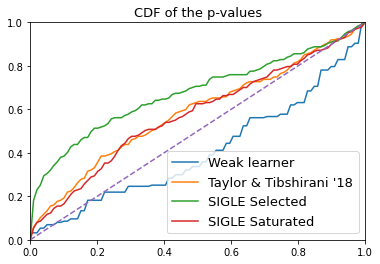

In [131]:
lists_pvalues = [lspvals_naive, lspvals_tay, lspvals_selec, lspvals_sat]
names = ['Weak learner', "Taylor & Tibshirani '18", 'SIGLE Selected', 'SIGLE Saturated']
plot_cdf_pvalues(lists_pvalues, names, name_figsave=None)

#### Checking the conditional CLT

In [110]:
def monome(coors, path=None):
    # Data
    n,p = 15,10
    lamb = 0.9
    d = 2
    theta = 0*np.ones(d)
    truetheta = np.zeros(p)
    truetheta[:d] = theta
    np.random.seed(1)
    rescale = 2*np.sqrt(n)/p
    X = rescale * np.random.normal(0,1,(n,p))
    matXtrue = X[:,:d]
    sig = sigmoid(matXtrue @ theta)
    yobs = np.random.rand(n) <= sig
    model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
    model.fit(X, yobs)
    theta_obs = model.coef_[0]
    M = np.where( np.abs(theta_obs) > 1e-5)[0]
    print("Selected support: ", M)

    # Exact expectation
    probas, states_exact = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False)

    mean_exact = 0
    for k,y in enumerate(states_exact):
        mono = 1
        for i in coors:
            mono *= y[i]
        mean_exact += probas[k] * mono
    
    list_diff = []
    list_sizes = []   
    if path is None:

        #     list_logite = np.linspace(np.log(20000),np.log(100000),10)
        #     list_ite = np.array([int(np.exp(el)) for el in list_logite])
        #     for nb_ite in list_ite:
        count = 0
        maxcount = 0
        while (count <= 10 and maxcount<=20):
            nb_ite = np.random.randint(30000,200000)
            maxcount += 1
            states = SEI_by_sampling(sig, X, lamb, M, nb_ite=nb_ite)
            if len(states)>5:
                mean = 0
                for y in states:
                    mono = 1
                    for i in coors:
                        mono *= y[i]
                    mean += mono
                mean /= len(states)
                list_diff.append(np.abs(mean-mean_exact))
                list_sizes.append(len(states))
                count += 1
    else:
        from os import listdir
        from os.path import isfile, join
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        indexes = []
        for file in onlyfiles:
            if file[:12]=='sampling_res':
                indexes.append(file[12:-4])
        for idx in indexes:
            states = np.load(path+'sampling_res'+idx+'.npy')
            mean = 0
            for y in states:
                mono = 1
                for i in coors:
                    mono *= y[i]
                mean += mono
            mean /= len(states)
            list_diff.append(np.abs(mean-mean_exact))
            list_sizes.append(len(states))
    return list_diff, list_sizes

In [111]:
list_diff, list_sizes = monome([1], path='parallel_sampling_res/')

Selected support:  [0 2 6 9]


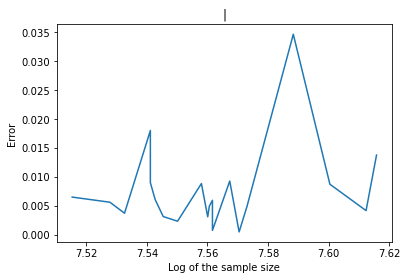

In [112]:
idxs_sizes = np.argsort(list_sizes)
lssizes = np.array([np.log(list_sizes[idxs_sizes[i]]) for i in range(len(list_sizes))])
list_diff = np.array(list_diff)
plt.plot(lssizes, list_diff[idxs_sizes])
plt.xlabel('Log of the sample size')
plt.ylabel('Error')
plt.title('$|\frac{1}{n_s} \sum h(Y^c) - \bar \mathbb E h(Y) |$')
plt.show()

In [113]:
list_sizes

[1901,
 1923,
 2030,
 1945,
 1916,
 1999,
 1884,
 1920,
 1887,
 1940,
 1859,
 1975,
 2023,
 1884,
 1836,
 1921,
 1923,
 1868,
 1892,
 1934]

In [101]:
from ipyparallel import Client

c = Client()
print(c.ids)
dview = c[:]
import numpy as np

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [118]:
@dview.remote(block = True)
def parallel_sampling(path):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.integrate import odeint
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
    from inverse_map import inverse_map, train_network
    import torch
    import scipy
    import scipy as sc
    import scipy.stats


    def sigmoid(u):
        """Sigmoid function."""
        return (1/(1+np.exp(-u)))
    
    
    def equalset(A,B):
        """Checks if two sets of integers are equal.

        Parameters
        ----------
        A, B : lists or sets of integers.

        Returns
        -------
        A boolean which is True if and only if the sets A and B are equal.
        """
        res = True
        for a in A:
            if a not in B:
                res = False
        return res

    def SEI_by_sampling(sig, X, lamb, M, remove_repetitions=False, nb_ite=100000):
        """Computes states belonging to the selection event.

        Parameters
        ----------
        sig : list of float
            unconditional expectation of the response vector.
        X : 2 dimensional matrix
            design matrix.
        lamb : float
            regularization parameter for the l1-penalty.
        M : array of integers
            selected support.

        Returns
        -------
        states : vectors of the hypercube belonging to the selection event.

        Note
        ----
        Each vector appearing in the returned list is present only once. Note that the set of states returned be the algorithm might not contains all the vectors belonging to the selection event.
        """
        saved_states = []
        count = 0
        n,p = X.shape
        for i in range(nb_ite):
            y = np.random.rand(n)<=sig
            # We compute the solution of the Sparse Logistic Regression with the current 'y'
            if np.sum(y) not in [0,n]:
                model = LogisticRegression(penalty='l1', C = 1/lamb, solver='liblinear', fit_intercept=False)
                model.fit(X, y)
                theta_hat = model.coef_[0]
                M2 = np.where( np.abs(theta_hat) > 1e-5)[0]
                if equalset(M,M2) and (len(M)==len(M2)):
                    saved_states.append(y)
                    count += 1
            if (count-1)%20==0:
                print(count,' states in the selection event found so far')
                count += 1
        if remove_repetitions:
            states = [list(item) for item in set(tuple(row) for row in saved_states)]
        return saved_states
    
    n,p = 15,10
    lamb = 1
    d = 2
    theta = 0*np.ones(d)
    truetheta = np.zeros(p)
    truetheta[:d] = theta
    np.random.seed(1)
    rescale = 2*np.sqrt(n)/p
    X = rescale * np.random.normal(0,1,(n,p))
    matXtrue = X[:,:d]
    sig = sigmoid(matXtrue @ theta)
    yobs = np.random.rand(n) <= sig
    model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
    model.fit(X, yobs)
    theta_obs = model.coef_[0]
    M = np.where( np.abs(theta_obs) > 1e-5)[0]
    print("Selected support: ", M)
#     logite = np.random.uniform(np.log(3000),np.log(3000000))
#     nb_ite = int(np.exp(logite))
    nb_ite = np.random.randint(3000,30000)

    import os
    idjob = os.getpid()
    np.random.seed()

    states = SEI_by_sampling(sig, X, lamb, M, nb_ite=nb_ite)
    np.save(path+'sampling_res'+str(idjob+np.random.randint(0,1000))+'.npy',states)

In [119]:
parallel_sampling('parallel_sampling_res/')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

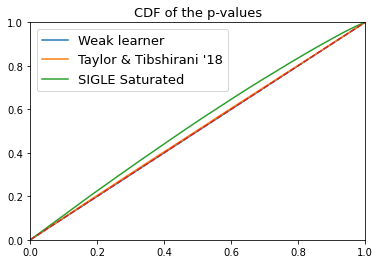

In [118]:
lists_pvalues = [lspvals_naive, lspvals_tay, lspvals_sat]
names = ['Weak learner', "Taylor & Tibshirani '18", 'SIGLE Saturated']
plot_cdf_pvalues(lists_pvalues, names, name_figsave='global_null_sat.png')

##### Checking assumption of the Conditional CLT

In [ ]:
coarse_upper_bound, upper_bound = upper_bound_condition_CCLT(states,X,barpi,tildeGN_12,M)
print("Coarse Upper bound (Theorem statement): ", coarse_upper_bound)
print("Upper bound (weaker requirement obtained in the proof): ", upper_bound)
print("-> Both should tend to 0 as n grows.")

### We check that the Conditional CLT is working

###### 1) Expectations of some monomes

In [ ]:
def monome(coors, path=None):
    # Data
    n,p = 15,10
    lamb = 0.9
    d = 2
    theta = 0*np.ones(d)
    truetheta = np.zeros(p)
    truetheta[:d] = theta
    np.random.seed(1)
    rescale = 2*np.sqrt(n)/p
    X = rescale * np.random.normal(0,1,(n,p))
    matXtrue = X[:,:d]
    sig = sigmoid(matXtrue @ theta)
    yobs = np.random.rand(n) <= sig
    model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
    model.fit(X, yobs)
    theta_obs = model.coef_[0]
    M = np.where( np.abs(theta_obs) > 1e-5)[0]
    print("Selected support: ", M)

    # Exact expectation
    probas, states_exact = true_conditional_distribution(theta_obs,X,yobs,lamb,truetheta,conditioning_signs=False)

    mean_exact = 0
    for k,y in enumerate(states_exact):
        mono = 1
        for i in coors:
            mono *= y[i]
        mean_exact += probas[k] * mono
    
    list_diff = []
    list_sizes = []   
    if path is None:

        #     list_logite = np.linspace(np.log(20000),np.log(100000),10)
        #     list_ite = np.array([int(np.exp(el)) for el in list_logite])
        #     for nb_ite in list_ite:
        count = 0
        maxcount = 0
        while (count <= 10 and maxcount<=20):
            nb_ite = np.random.randint(30000,200000)
            maxcount += 1
            states = SEI_by_sampling(sig, X, lamb, M, nb_ite=nb_ite)
            if len(states)>5:
                mean = 0
                for y in states:
                    mono = 1
                    for i in coors:
                        mono *= y[i]
                    mean += mono
                mean /= len(states)
                list_diff.append(np.abs(mean-mean_exact))
                list_sizes.append(len(states))
                count += 1
    else:
        from os import listdir
        from os.path import isfile, join
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        indexes = []
        for file in onlyfiles:
            if file[:12]=='sampling_res':
                indexes.append(file[12:-4])
        for idx in indexes:
            states = np.load(path+'sampling_res'+idx+'.npy')
            mean = 0
            for y in states:
                mono = 1
                for i in coors:
                    mono *= y[i]
                mean += mono
            mean /= len(states)
            list_diff.append(np.abs(mean-mean_exact))
            list_sizes.append(len(states))
    return list_diff, list_sizes

In [ ]:
list_diff, list_sizes = monome([1], path='parallel_sampling_res/')

In [ ]:
idxs_sizes = np.argsort(list_sizes)
lssizes = np.array([np.log(list_sizes[idxs_sizes[i]]) for i in range(len(list_sizes))])
list_diff = np.array(list_diff)
plt.plot(lssizes, list_diff[idxs_sizes])
plt.xlabel('Log of the sample size')
plt.ylabel('Error')
plt.title('$|\frac{1}{n_s} \sum h(Y^c) - \bar \mathbb E h(Y) |$')
plt.show()

In [ ]:
from ipyparallel import Client

c = Client()
print(c.ids)
dview = c[:]
import numpy as np

@dview.remote(block = True)
def parallel_sampling(path):
    """Samples states from the conditional distribution. This is done in parallel with different random seed in order to save multiple files in order to aggregate with the function 'monome'.
    
    Parameters
    ----------
    path: path (ending with '/') where the files containing states sampled from the conditional distribution will be saved.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.integrate import odeint
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
    from inverse_map import inverse_map, train_network
    import torch
    import scipy
    import scipy as sc
    import scipy.stats


    def sigmoid(u):
        """Sigmoid function."""
        return (1/(1+np.exp(-u)))
    
    
    def equalset(A,B):
        """Checks if two sets of integers are equal.

        Parameters
        ----------
        A, B : lists or sets of integers.

        Returns
        -------
        A boolean which is True if and only if the sets A and B are equal.
        """
        res = True
        for a in A:
            if a not in B:
                res = False
        return res

    def SEI_by_sampling(sig, X, lamb, M, remove_repetitions=False, nb_ite=100000):
        """Computes states belonging to the selection event.

        Parameters
        ----------
        sig : list of float
            unconditional expectation of the response vector.
        X : 2 dimensional matrix
            design matrix.
        lamb : float
            regularization parameter for the l1-penalty.
        M : array of integers
            selected support.

        Returns
        -------
        states : vectors of the hypercube belonging to the selection event.

        Note
        ----
        Each vector appearing in the returned list is present only once. Note that the set of states returned be the algorithm might not contains all the vectors belonging to the selection event.
        """
        saved_states = []
        count = 0
        n,p = X.shape
        for i in range(nb_ite):
            y = np.random.rand(n)<=sig
            # We compute the solution of the Sparse Logistic Regression with the current 'y'
            if np.sum(y) not in [0,n]:
                model = LogisticRegression(penalty='l1', C = 1/lamb, solver='liblinear', fit_intercept=False)
                model.fit(X, y)
                theta_hat = model.coef_[0]
                M2 = np.where( np.abs(theta_hat) > 1e-5)[0]
                if equalset(M,M2) and (len(M)==len(M2)):
                    saved_states.append(y)
                    count += 1
            if (count-1)%20==0:
                print(count,' states in the selection event found so far')
                count += 1
        if remove_repetitions:
            states = [list(item) for item in set(tuple(row) for row in saved_states)]
        return saved_states
    
    n,p = 15,10
    lamb = 1
    d = 2
    theta = 0*np.ones(d)
    truetheta = np.zeros(p)
    truetheta[:d] = theta
    np.random.seed(1)
    rescale = 2*np.sqrt(n)/p
    X = rescale * np.random.normal(0,1,(n,p))
    matXtrue = X[:,:d]
    sig = sigmoid(matXtrue @ theta)
    yobs = np.random.rand(n) <= sig
    model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
    model.fit(X, yobs)
    theta_obs = model.coef_[0]
    M = np.where( np.abs(theta_obs) > 1e-5)[0]
    print("Selected support: ", M)
#     logite = np.random.uniform(np.log(3000),np.log(3000000))
#     nb_ite = int(np.exp(logite))
    nb_ite = np.random.randint(3000,30000)

    import os
    idjob = os.getpid()
    np.random.seed()

    states = SEI_by_sampling(sig, X, lamb, M, nb_ite=nb_ite)
    np.save(path+'sampling_res'+str(idjob+np.random.randint(0,1000))+'.npy',states)

##### 2) Visualizing the conditional distribution

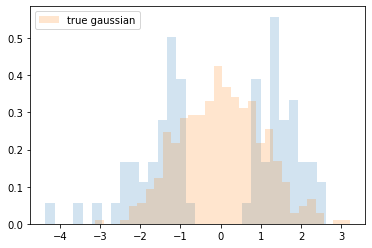

In [20]:
matXtrue = X[:,M]
rho = matXtrue.T @ barpi.T
try:
    tildetheta = net(torch.from_numpy(rho.T).float())
    tildetheta = tildetheta.detach().numpy()
except:
    model = LogitRegressionContinuous()
    model.fit(matXtrue, barpi)
    tildetheta = model.coef_
tildeGN = matXtrue.T @ np.diag(barpi*(np.ones(n)-barpi)) @ matXtrue
usvd,s,vt = np.linalg.svd(tildeGN)
tildeGN_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt
GNtilde = matXtrue.T @ np.diag(sigmoid1(matXtrue @ tildetheta)) @ matXtrue
VN = tildeGN_12 @ GNtilde

lsstat = []
u  = np.random.normal(0,1,len(M))
u /= np.linalg.norm(u)
u = np.zeros(len(M))
u[0] = 1
lspvals_selec = []
for i in range(len(states)):
    y = np.array(states[i])
    # selected
    model = LogisticRegression(C=10000, solver='liblinear', fit_intercept=False)
    model.fit(matXtrue, y)
    theta = model.coef_[0]
    stat = u.T @ VN @ (theta - tildetheta)
    lsstat.append(stat)
    stat2 = np.linalg.norm( VN @ (theta - tildetheta))**2
    lspvals_selec.append(1-scipy.stats.chi2.cdf(stat2, len(M)))
a= plt.hist(lsstat, density=True, alpha=0.2, bins=30)
b = np.random.normal(0,1,500)
c = plt.hist(b,density=True, bins=30, alpha=0.2, label='true gaussian')
plt.legend()

(array([3.00000e+00, 2.00000e+00, 1.00000e+00, 6.00000e+00, 1.40000e+01,
        2.20000e+01, 5.10000e+01, 1.66000e+02, 8.07000e+02, 2.63669e+05]),
 array([0.99999993, 0.99999994, 0.99999995, 0.99999995, 0.99999996,
        0.99999997, 0.99999997, 0.99999998, 0.99999999, 0.99999999,
        1.        ]),
 <BarContainer object of 10 artists>)

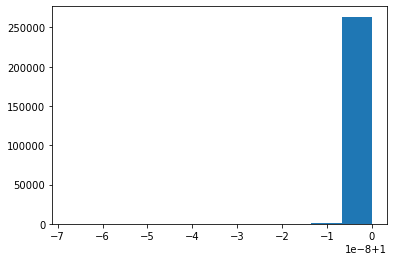

In [21]:
a = plt.hist(lspvals_selec)

In [22]:
rho = matXtrue.T @ barpi
tildetheta = net(torch.from_numpy(rho.T/rescale**2).float())
the = tildetheta.detach().numpy()
print(rho, matXtrue.T @sigmoid(matXtrue @ (the)/rescale**2), the)

[  4.86312698   2.6965552   74.78306205 -40.34741306 -42.51979641
  76.88916706  10.48703625  35.04030318  -9.42070338] [  6.71694963   2.13451877  89.43589674 -46.31878479 -49.74717124
  93.27580388  12.47139661  41.12657396 -10.17301964] [ 3.0843280e-02  7.2348416e-03  1.3404906e-01 -4.8511386e-02
 -7.2319046e-02  1.7453001e-01  8.5245818e-05  4.5916647e-02
 -1.7582081e-02]


In [94]:
model = LogitRegressionContinuous()
model.fit( matXtrue, barpi)
tildetheta = model.coef_
print( matXtrue.T @ barpi, matXtrue.T @sigmoid(matXtrue @ (tildetheta)), tildetheta)

[-0.0888546   1.32551961  6.71912457 15.39023271  4.73602669 -8.26528623
  1.07773551  0.32052589  4.16137539  3.79704289] [-0.08903855  1.32661835  6.72445069 15.40254043  4.73966371 -8.27186819
  1.07847033  0.32067038  4.16455357  3.79999962] [ 0.00454368  0.00218084 -0.0005032  -0.00110934  0.00231096  0.00040413
  0.00218441  0.00202103  0.00502457  0.00287753]


In [129]:
import numpy as np
from sklearn.linear_model import LinearRegression


class LogitRegressionContinuous(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)


if __name__ == '__main__':
    # generate example data
    model = LogitRegression()
    model.fit( matXtrue, barpi)

    print(model.coef_)
    # [[  2.06115362e-09]
    #  [  5.00000000e-01]
    print( matXtrue.T @ barpi, matXtrue.T @ sigmoid(matXtrue @ model.coef_))

In [ ]:
matXtrue = X[:,M]

idxs = np.random.choice([i for i in range(len(states))], size=300, p=probasalt)

mean = np.zeros(n)
norma = 0
for j in idxs[:250]:
    y = states[j]
    mean += np.array(y) * probasalt[j]
    norma += probasalt[j]
    rho = matXtrue.T @ y
    tildetheta = net(torch.from_numpy(rho.T).float())
    the = tildetheta.detach().numpy()
    #print(rho, matXtrue.T @ sigmoid(matXtrue @ the),the)
    
    model = LogisticRegression(C=10000, solver='liblinear', fit_intercept=False)
    model.fit(X, y)
    theta_obs = model.coef_[0]
    print('THETA', theta_obs)
print(mean / norma)

# 0) To launch on a cluster the rejection sampling algo for different sets of parameters 

In [ ]:
from ipyparallel import Client

c = Client()
print(c.ids)
dview = c[:]
import numpy as np

In [ ]:

@dview.remote(block = True)
def logPSI(settings):

    import numpy as np
    import torch.optim as optim
    import matplotlib.pyplot as plt
    from scipy.integrate import odeint
    from inverse_map import inverse_map, train_network
    import torch
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
    import os
    import pickle

    
               
    
    idjob = os.getpid()
    np.random.seed()
    idjob += np.random.randint(1,1000)
    
    path='dataEM/'


    def sigmoid(u):
        """Sigmoid function."""
        return (1/(1+np.exp(-u)))

    def equalset(A,B):
        """Checks if two sets of integers are equal.

        Parameters
        ----------
        A, B : lists or sets of integers.

        Returns
        -------
        A boolean which is True if and only if the sets A and B are equal.
        """
        res = True
        for a in A:
            if a not in B:
                res = False
        return res
    def SEI_by_sampling(sig, X, lamb, M):
        """Computes states belonging to the selection event.

        Parameters
        ----------
        sig : list of float
            unconditional expectation of the response vector.
        X : 2 dimensional matrix
            design matrix.
        lamb : float
            regularization parameter for the l1-penalty.
        M : array of integers
            selected support.

        Returns
        -------
        states : vectors of the hypercube belonging to the selection event.

        Note
        ----
        Each vector appearing in the returned list is present only once. Note that the set of states returned be the algorithm might not contains all the vectors belonging to the selection event.
        """
        saved_states = []
        count = 0
        n,p = X.shape
        for i in range(1000000):
            y = np.random.rand(n)<=sig
            # We compute the solution of the Sparse Logistic Regression with the current 'y'
            if np.sum(y) not in [0,n]:
                model = LogisticRegression(penalty='l1', C = 1/lamb, solver='liblinear', fit_intercept=False)
                model.fit(X, y)
                theta_hat = model.coef_[0]
                M2 = np.where( np.abs(theta_hat) > 1e-5)[0]
                if equalset(M,M2) and (len(M)==len(M2)):
                    saved_states.append(y)
                    count += 1
            if (count-1)%20==0:
                print(count,' states in the selection event found so far')
                count += 1
        states = [list(item) for item in set(tuple(row) for row in saved_states)]
        return states

    for idx,setting in enumerate(settings):
        n,p = setting['n'], setting['p']
        
        lamb = setting['lamb']

        d = 2
        theta = 0*np.ones(d)
        truetheta = np.zeros(p)
        truetheta[:d] = theta

        np.random.seed(1)
        X = np.random.normal(0,1,(n,p))
        if setting['normalize']:
            X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
        matXtrue = X[:,:d]

        sig = sigmoid(matXtrue @ theta)
        yobs = np.random.rand(n) <= sig
        if lamb==-1:
            if setting['normalize']:
                model = LogisticRegressionCV(Cs = [0.05*(i+1) for i in range(33)], penalty='l1', solver='liblinear', fit_intercept=False)
            else:
                model = LogisticRegressionCV(Cs = [0.5*(i+1) for i in range(33)], penalty='l1', solver='liblinear', fit_intercept=False)
            model.fit(X, yobs)
            lamb = 1/model.C_[0]
        else:
            model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
            model.fit(X, yobs)
        theta_obs = model.coef_[0]
        M = np.where( np.abs(theta_obs) > 1e-5)[0]
        np.save(path+str(idx)+'_'+str(idjob)+'_M.npy',M)
        np.save(path+str(idx)+'_'+str(idjob)+'_yobs.npy',yobs)
        np.save(path+str(idx)+'_'+str(idjob)+'_lamb.npy',np.array([lamb]))

        with open(path+str(idx)+'_setting.pkl', 'wb') as f:
            pickle.dump(setting, f)
        states = SEI_by_sampling(sig, X, lamb, M)
        np.save(path+str(idx)+'_'+str(idjob)+'_states.npy',states)



In [ ]:
settings = [ {'n':200,'lamb':10,'p':20,'normalize':False}, 
                {'n':200,'lamb':5,'p':10,'normalize':False},
                {'n':50,'lamb':4,'p':30,'normalize':False},
                {'n':50,'lamb':6,'p':30,'normalize':False},
                {'n':50,'lamb':3,'p':15,'normalize':False},
                {'n':200,'lamb':0.4,'p':20,'normalize':True}, 
                {'n':200,'lamb':0.4,'p':10,'normalize':True},
                {'n':50,'lamb':0.5,'p':30,'normalize':True},
                {'n':50,'lamb':0.7,'p':30,'normalize':True},
                {'n':50,'lamb':3,'p':15,'normalize':True},
                {'n':200,'lamb':-1,'p':20,'normalize':False}, 
                {'n':200,'lamb':-1,'p':10,'normalize':False},
                {'n':50,'lamb':-1,'p':30,'normalize':False},
                {'n':50,'lamb':-1,'p':30,'normalize':False},
                {'n':50,'lamb':-1,'p':15,'normalize':False},
               ]
logPSI()

In [ ]:
path = 'dataEM/'
num = '4'

setting = settings[int(num)]

# Finding all the saved experiments
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
indexes = []
for file in onlyfiles:
    if file[:2]==num+'_' and file[::-1][:6]=='ypn.M_':
        indexes.append(file[:-6])
print('Total of number of simulated annealing:', len(indexes))

In [ ]:
saved_states = []
for idx in indexes:
    sta = np.load('dataEM/'+idx+'_states.npy')
    saved_states += list(sta) 
    
states = [list(item) for item in set(tuple(row) for row in saved_states)]
print(len(states))

In [ ]:
n,p = setting['n'], setting['p']

lamb = setting['lamb']

d = 2
theta = 0*np.ones(d)
truetheta = np.zeros(p)
truetheta[:d] = theta

np.random.seed(1)
X = np.random.normal(0,1,(n,p))
if setting['normalize']:
    X /= np.tile(np.linalg.norm(X,axis=0),(n,1))
matXtrue = X[:,:d]

sig = sigmoid(matXtrue @ theta)
yobs = np.random.rand(n) <= sig
if lamb==-1:
    if setting['normalize']:
        model = LogisticRegressionCV(Cs = [0.05*(i+1) for i in range(33)], penalty='l1', solver='liblinear', fit_intercept=False)
    else:
        model = LogisticRegressionCV(Cs = [0.5*(i+1) for i in range(33)], penalty='l1', solver='liblinear', fit_intercept=False)
    model.fit(X, yobs)
    lamb = 1/model.C_[0]
else:
    model = LogisticRegression(C = 1/lamb, penalty='l1', solver='liblinear', fit_intercept=False)
    model.fit(X, yobs)
theta_obs = model.coef_[0]
M = np.where( np.abs(theta_obs) > 1e-5)[0]

thetanull = np.copy(truetheta)
signull = sigmoid(X @ thetanull)